<a href="https://colab.research.google.com/github/Freya-LR/strategic_network/blob/master/Stable_Network_Generaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, FigureCanvasPdf
from matplotlib.figure import Figure
import pandas as pd
from itertools import chain, combinations
import random as rnd
import time
import collections
from multiprocessing import Pool
from multiprocessing.dummy import Pool as ThreadPool
import multiprocessing as mp
import pickle
import openpyxl
import xlsxwriter
import warnings

warnings.filterwarnings('ignore')

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14




In [ ]:
# __ takes a graph, and a cost matrix, and returns the cost of each node as a vector
def Cost_matrix(G,C):
    adj_mat=nx.to_numpy_matrix(G)
    mul_mat=np.matmul(C,np.transpose(adj_mat))
    C_list=mul_mat.diagonal()
    return C_list.tolist()[0]

# Calculates node utility by taking the network (G), benefit vector and Cost matrix (this is used in the next function)
def node_utility_general(node,G,b,C,depth=3):
    z = nx.single_source_shortest_path_length(G,node,depth)
    benefit = sum ( [ b[z[k]] for k in z]  )
    cost = Cost_matrix(G,C)[node]
    return benefit - cost

# Returns all the node utilities
def all_utils_general(g,b,C,depth=3):
    node_utils= [node_utility_general(k,g,b,C,) for k in g.nodes()]
    return node_utils

#Calculates network utilities ofr each node and sets them as node attributes
def set_network_util_attributes(g,b,C,depth=3):
    utils=all_utils_general(g,b,C,depth=depth)
    dict_util={}
    for i in g.nodes():
        dict_util[i]=round(utils[i],2)
    nx.set_node_attributes(g, dict_util, 'utility')   
    return g

""" We seperate the sources of instability in networks into two categories: Frustration and envy. Frustration is when one node
wants to remove one of its links. Envy is when two nodes want to form a link that currently doesn't exist. We look at the impact of each of these facots seperately
by generating no frustration and no envy networks. Then we combine the two and find stable networks."""

#__for a given node, v, returns neighbors to whome v wants to disconnect the tie, and the difference in utility that is saved.
def frust_test_general(g,v,b,cx,depth=3):
    u_0=node_utility_general(v,g,b,cx,depth)
    bad_neighbors=[]
    for ng in g.neighbors(v):
        g_tmp=g.copy()
        g_tmp.remove_edge(v,ng)
        u_new = node_utility_general(v,g_tmp,b,cx,depth)
        if u_new > u_0:
            bad_neighbors.append([v,ng,u_new-u_0])
    return bad_neighbors

#Takes network and cost and benefit parameters and returns the list of frustrated nodes
def total_frust_list_general(g,b,c,depth=3):
    total_list=[]
    for v in g.nodes():
        total_list+=frust_test_general(g,v,b,c,depth)
    return total_list

# Takes a network as an input, and returns all the links that both ends would agree with adding (envy list)
def missed_opts_general(g,b,cx,depth=3):
    node_utils= [node_utility_general(k,g,b,cx,depth) for k in g.nodes()]
    missing_links=[]
    for e in list(nx.edges(nx.complement(g))):
        g_tmp=g.copy()
        g_tmp.add_edge(*e)
        us_shift=node_utility_general(e[0],g_tmp,b,cx,depth)-node_utils[e[0]]
        ud_shift=node_utility_general(e[1],g_tmp,b,cx,depth)-node_utils[e[1]]
        if ((us_shift>=0 and ud_shift>=0) and (abs(us_shift)+abs(ud_shift)!= 0)):
            missing_links.append(e)
    return missing_links

#Takes a network, starts removing edges till it gets to a no-frustraction network
def find_no_frustration_network_general(g,b,cx,depth=3,M=1000):
    f_list=total_frust_list_general(g,b,cx,depth)
    g_tmp=g.copy()
    while ((f_list) and (M>0)):
        e_rem=rnd.choice(f_list)
        g_tmp.remove_edge(e_rem[0],e_rem[1])
        f_list=total_frust_list_general(g_tmp,b,cx,depth)
        M=M-1
    return g_tmp,M
#Takes a network, starts adding links till it gets to a no-envy network

def find_no_envy_network_general(g,b,cx,depth=3,M=1000):
    en_list=missed_opts_general(g,b,cx,depth)
    g_tmp=g.copy()
    while ((en_list) and (M>0)):
        e_add=rnd.choice(en_list)
        g_tmp.add_edge(*e_add)
        en_list=missed_opts_general(g_tmp,b,cx,depth)
        #print(len(en_list))
        M=M-1
    return g_tmp,M

"""Here we combine the two factors to find stable networks. The following function takes network parameters, first calculates and sets
utilities of each node. Then create a list of frustrated nodes and envy-generating links. Then at each time step moves one step
towards lowering envy and one step towards reducing frustration (M determines the number of steps in each process). depth is the 
maximum distance for which node payoffs are calculated."""

def find_stable_network_general(g,b,cx,depth=3,N=1000,M=1):
    Steps=N
    set_network_util_attributes(g,b,cx,depth=depth)
    g_sequence=[]
    gt=g.copy()
    L1=total_frust_list_general(gt,b,cx,depth)
    L2=missed_opts_general(gt,b,cx,depth)
    while ((len(L1)>0 or (len(L2)>0)) and (N>0)):
        g_no_frust,Mf=find_no_frustration_network_general(gt,b,cx,depth,M)
        g_no_envy,Me=find_no_envy_network_general(g_no_frust,b,cx,depth,M)
        gt=g_no_envy
        L1=total_frust_list_general(gt,b,cx)
        L2=missed_opts_general(gt,b,cx)
        N=N-1
        set_network_util_attributes(gt,b,cx,depth=depth)
        g_sequence.append(gt)
        #print(N)
    return gt,Steps-N,g_sequence



"""The following 3 functions are related to the special case of seperable cost"""

#This function creates a cost matrix for the special case where costs are sepearble, which is when Cij = Ci + Cj, thus we need to 
#start with a cost vector (Cvec)
def seperable_cost(Cvec):
    n=len(Cvec)   
    CM=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            CM[i,j]=Cvec[i]
    return CM

#returns the total utility (the assumption node utilities are already registered in the network)

def total_utility(G):
    U=0
    for i in G.nodes():
        U+=G.nodes()[i]['utility']
    return U

# This reutnrs the unique effiecnet network (the algorithm is based on a paper (Heydari, Mosleh (2015))) 
        #if G.nodes[node]['utility']<0:

def seperable_efficient_network(b,C):
    n=len(C)
    G=nx.empty_graph(n)
    m=1  
    RHS=C[0]-2*b[1]
    print('RHS',RHS)
    LHS=2*(m-1)*b[2]-C[m]  # for i in range(n), nodes start from 1 to n, m is the largest integer
       # between 1 and n, m={2,n}, but in function nodes start from 0 to n-1, let t=m-1, m=t+1,  so 
        # LHS=2(m-2)-C[m-1] turn to LHS=2(t-1)-C[t]
    print('LHS',LHS)
    while ((LHS >= RHS) and (m < n)):
        #print('This is m:',m)
        #print('LHS',LHS)
        m+=1
        if m==n:
            break
        LHS=2*(m-1)*b[2]-C[m]
        
    if m > n:
        print('No Efficient Network Exists!')
    
    m=m-1
    
    
    connected_nodes=[]
    for i in range(1, m + 1):
        G.add_edge(0, i)
        for j in range(i+1, m + 1):
            if (b[1] - b[2]) >= 0.5 * (C[i] + C[j]):
                G.add_edge(i, j)
                connected_nodes.append([i,j])
    
    return G,m
    

In [ ]:
"""The following functions relaxes the conecpt of stability by allowing bilateral exchange"""
def missed_opts_general_barg_bac(g,b,cx,neg_cost=0,depth=3):
    node_utils= [node_utility_general(k,g,b,cx) for k in g.nodes()]
    missing_links=[]
    for e in list(nx.edges(nx.complement(g))):
        g_tmp=g.copy()
        g_tmp.add_edge(*e)
        us_shift=node_utility_general(e[0],g_tmp,b,cx,depth)-node_utils[e[0]]
        ud_shift=node_utility_general(e[1],g_tmp,b,cx,depth)-node_utils[e[1]]
        if ((us_shift*ud_shift>=0) and (us_shift+ud_shift>0)):
            missing_links.append(e)
        elif ((us_shift*ud_shift<0) and (us_shift+ud_shift>neg_cost)):
            missing_links.append(e)
    return missing_links
def missed_opts_general_barg(g,b,cx,neg_cost=0,depth=3):
    node_utils= [node_utility_general(k,g,b,cx,depth=3) for k in g.nodes()]
    missing_links=[]
    for e in list(nx.edges(nx.complement(g))):
        g_tmp=g.copy()
        g_tmp.add_edge(*e)
        us_shift=node_utility_general(e[0],g_tmp,b,cx,depth=3)-node_utils[e[0]]
        ud_shift=node_utility_general(e[1],g_tmp,b,cx,depth=3)-node_utils[e[1]]
        if (us_shift+ud_shift>0):
            missing_links.append(e)
        elif ((us_shift*ud_shift<0) and (us_shift+ud_shift>neg_cost)):
            missing_links.append(e)
    return missing_links
def frust_list_general_barg(g,b,cx,neg_cost=0,depth=3):
    node_utils= [node_utility_general(k,g,b,cx,depth=3) for k in g.nodes()]
    frust_list=[]
    for e in list(nx.edges(g)):
        g_tmp=g.copy() 
        us_shift=node_utility_general(e[0],g_tmp,b,cx)-node_utils[e[0]]
        ud_shift=node_utility_general(e[1],g_tmp,b,cx)-node_utils[e[1]]
        if ((us_shift+ud_shift) > -neg_cost):
            frust_list.append(e)
    return frust_list
def find_no_frustration_network_general_barg(g,b,cx,neg_cost=0,depth=3,M=1000):
    f_list=frust_list_general_barg(g,b,cx,neg_cost=0,depth=depth)
    g_tmp=g.copy()
    while ((f_list) and (M>0)):
        e_rem=rnd.choice(f_list)
        g_tmp.remove_edge(e_rem[0],e_rem[1])
        f_list=total_frust_list_general(g_tmp,b,cx,depth)
        M=M-1
    return g_tmp,M
def find_no_envy_network_general_barg(g,b,cx,neg_cost=0,depth=3,M=1000):
    en_list=missed_opts_general_barg(g,b,cx,neg_cost=neg_cost,depth=depth)
    g_tmp=g.copy()
    while ((en_list) and (M>0)):
        e_add=rnd.choice(en_list)
        g_tmp.add_edge(*e_add)
        en_list=missed_opts_general_barg(g_tmp,b,cx,neg_cost=0,depth=depth)
        #print(len(en_list))
        M=M-1
    return g_tmp,M
def find_stable_network_general_barg(g,b,cx,depth=3,N=500,M1=1,M2=1,neg_cost_f=0,neg_cost_e=0):
    Steps=N
    set_network_util_attributes(g,b,cx,depth=depth)
    g_sequence=[]
    gt=g.copy()
    L1=frust_list_general_barg(gt,b,cx,neg_cost=neg_cost_f,depth=depth)
    L2=missed_opts_general_barg(gt,b,cx,neg_cost=neg_cost_e,depth=depth)
    while ((len(L1)>0 or (len(L2)>0)) and (N>0)):
        g_no_frust,Mf=find_no_frustration_network_general_barg(gt,b,cx,neg_cost=neg_cost_f,depth=depth,M=M1)
        g_no_envy,Me=find_no_envy_network_general_barg(g_no_frust,b,cx,neg_cost=neg_cost_e,depth=depth,M=M2)
        gt=g_no_envy
        L1=frust_list_general_barg(gt,b,cx,neg_cost=neg_cost_f,depth=depth)
        L2=missed_opts_general_barg(gt,b,cx,neg_cost=neg_cost_e,depth=depth)
        N=N-1
        set_network_util_attributes(gt,b,cx,depth=depth)
        g_sequence.append(gt)
        #print(N)
        #print(len(L1),len(L2))
    return gt,Steps-N,g_sequence

In [ ]:
"""efficient networks"""

def efficient_network(benefit,Cost):
    G1,m=seperable_efficient_network(benefit,Cost)
    CMS=seperable_cost(Cost)
    L=all_utils_general(G1,b,CMS)
    effi_network=sum(L)
    
    return effi_network, G1,m

In [ ]:
"""find stable network and characteristic"""
def stable_network_characteristic(b,Cve):    
    G_in=nx.erdos_renyi_graph(len(Cve),0.1)
    CMS=seperable_cost(Cve)
    '''find stable network'''
    
    G,NN,G_T=find_stable_network_general_barg(G_in,b,CMS,depth=4,N=1000,M1=10,M2=1)
    Gcc = sorted(nx.connected_components(G), key=len, reverse=True)
    '''this is the stable network for each iteration'''
    giant = G.subgraph(Gcc[0])
    
    '''get the nodes utility list of stable network '''
    node_stable_util_list=all_utils_general(giant, b, CMS, depth=3)
    
    '''efficiency loss''' 
    
    stable_total_utility=total_utility(giant)
    eff_utility, G_1,m=efficient_network(b,Cve)
    efficiency_loss=eff_utility-stable_total_utility
    
    
    
    return  giant, node_stable_util_list,eff_utility, G_1,efficiency_loss,m



In [ ]:
def figure_stable(b,Cve):   
    
    '''get parameter list, stable network and node utility list from input benefit and cost matrix'''
    giant_stable, node_stable_util_l,eff_utility, G_efficient,efficiency_loss,m=stable_network_characteristic(b,Cve)

    '''draw the stable network labeled with color'''
    color_map=[]
    for node in giant_stable:
        if G_efficient.degree(node)<(len(Cve)-2):
            color_map.append('cadetblue')
        else: color_map.append('goldenrod')

    fig_stable=plt.figure(figsize=(8,8),dpi=50)
    nx.draw(giant_stable,pos=nx.spring_layout(giant_stable),node_size=1400, width=3, font_size=20,node_color=color_map, with_labels=True)
    plt.title('Stable network',fontsize=25)

    fig_pagerank=plt.figure(figsize=(8,8),dpi=50)
    pagerank=sorted(nx.pagerank(giant_stable).items(),reverse = True)
    first_degree_connected_nodes = list(giant_stable.neighbors(4))#7,4
    second_degree_connected_nodes = []
    for x in first_degree_connected_nodes:
        second_degree_connected_nodes+=list(giant_stable.neighbors(x))
    second_degree_connected_nodes.remove(4) #7,4
    second_degree_connected_nodes = list(set(second_degree_connected_nodes))
    subgraph_7 = nx.subgraph(giant_stable,first_degree_connected_nodes+second_degree_connected_nodes)

    node_color = ['yellow' if v ==4 else 'lightcoral' for v in subgraph_7] #v==7,4
    node_size =  [1700 if v == 4 else 1200 for v in subgraph_7]#v==7,4

    nx.draw(subgraph_7, pos=nx.spring_layout(subgraph_7), node_color=node_color,node_size=node_size, font_size=20,with_labels=True)

    plt.title('Page Rank',fontsize=25)
    fig_efficient=plt.figure(figsize=(8,8),dpi=50)

    nx.draw(G_efficient,pos=nx.spring_layout(G_efficient),node_size=1400,width=5, font_size=20,with_labels=True)
    plt.title('Efficient Network',fontsize=25)
    plt.show()
    return fig_stable, fig_pagerank, fig_efficient

In [ ]:
def paramiter_function(b,Cve):
    
    giant, node_stable_util_l,eff_utility, G_efficient,efficiency_loss,m=stable_network_characteristic(b,Cve)
    # number_of_isolated_nodes_stable_network=len(Cvec)-len(giant.nodes())
    
 
    node_number=nx.number_of_nodes(giant)
    pathlengths = []
    pathlength_array=np.empty([node_number,node_number])
    for v in giant.nodes():
        spl = dict(nx.single_source_shortest_path_length(giant, v))        
        for p in spl:
            pathlengths.append(spl[p])
            pathlength_array[v][p]=spl[p]  #shortest path length matrix
    average_shortest_path_length=sum(pathlengths) / len(pathlengths)
    
    # histogram of path lengths
    dist = {}
    for p in pathlengths:
        if p in dist:
            dist[p] += 1
        else:
            dist[p] = 1
    number_of_path_df = pd.DataFrame.from_dict(dist, orient='index')
    degree_of_nodes=list(giant.degree)

    print("---------Number of Stable Network:",len(G_T))
    return  all

In [ ]:
### 9 nodes network benefit and cost
#Cve=[0.3,0.4,1,1.2,1.3,1.5,1.6,1.8,1.9] #0<c<2, c<b1-b2
#b=[0,3.5,1.5,0.5,0.3]
#Cve=[1.6,1.8,1.9,2.1,2.2,2.3,2.5,2.6,2.8] #1.5<ci<3, 1=b1-b2<ci<b1=4
#b=[0,4,3,2,1]
#Cve=[0.5,0.7,1,1.2,1.6,2.0,2.6,2.8,2.9] #0<c<2, cj<b1-b2(=1.5)<ci<b1=4
#b=[0,4,2.5,1.5,0.5]

### 8 nodes network benefit and cost
#Cve=[0.3,0.4,1.2,1.3,1.5,1.6,1.8,1.9] #0<c<2, c<b1-b2
#b=[0,3.5,1.5,1,0.5]
#Cve=[1.8,1.9,2.1,2.2,2.3,2.5,2.6,2.9] #1.5<ci<3, 1=b1-b2<ci<b1=4
#b=[0,4,3,2,1]
#Cve=[0.5,0.7,1,1.2,1.6,2.0,2.6,2.8] #0<c<2, cj<b1-b2(=1.5)<ci<b1=4
#b=[0,4,2.5,1.5,0.5]

### 7 nodes network benefit and cost
#Cve=[0.4,1.2,1.3,1.5,1.6,1.8,1.9] #0<c<2, c<b1-b2
#b=[0,3.5,1.5,1,0.5]
#Cve=[1.8,1.9,2.1,2.2,2.3,2.5,2.6] #1.5<ci<3, 1=b1-b2<ci<b1=4
#b=[0,4,3,2,1]
#Cve=[0.7,1,1.2,1.6,2.0,2.6,2.8] #0<c<2, cj<b1-b2(=1.5)<ci<b1=4
#b=[0,4,2.5,1.5,0.5]

### 6 nodes network benefit and cost
#Cve=[0.4,1.2,1.5,1.6,1.8,1.9] #0<c<2, c<b1-b2
#b=[0,3.5,1.5,1,0.5]
#Cve=[1.8,1.9,2.1,2.2,2.3,2.5] #1.5<ci<3, 1=b1-b2<ci<b1=4
#b=[0,4,3,2,1]
#Cve=[0.5,0.7,1,2.0,2.6,2.8] #0<c<2, cj<b1-b2(=1.5)<ci<b1=4
#b=[0,4,2.5,1.5,0.5]

### 5 nodes network benefit and cost
#Cve=[1.3,1.5,1.6,1.8,1.9] #0<c<2, c<b1-b2
#b=[0,3.5,1.5,1,0.5]
#Cve=[2.1,2.2,2.3,2.5,2.6] #1.5<ci<3, 1=b1-b2<ci<b1=4
#b=[0,4,3,2,1]
#Cve=[0.5,0.7,1.5,2.6,2.8] #0<c<2, cj<b1-b2(=1.5)<ci<b1=4
#b=[0,4,2.5,1.5,0.5]

### 4 nodes network benefit and cost
#Cve=[1.3,1.5,1.6,1.8] #0<c<2, c<b1-b2
#b=[0,3.5,1.5,1,0.5]
#Cve=[2.1,2.2,2.3,2.5] #1.5<ci<3, 1=b1-b2<ci<b1=4
#b=[0,4,3,2,1]
#Cve=[0.7,1.5,2.6,2.8] #0<c<2, cj<b1-b2(=1.5)<ci<b1=4
#b=[0,4,2.5,1.5,0.5]

RHS -7.5
LHS -0.7
Iteration : 0
---Efficient Network(may not stable) Utility: 80.0000
---Stable Network Utility: 74.5000
---Efficiency Loss of Stable Network: 5.5000
The Largest m: 5
Numbers of Isolated Nodes: 0
RHS -7.5
LHS -0.7
RHS -7.5
LHS -0.7
Iteration : 1
---Efficient Network(may not stable) Utility: 80.0000
---Stable Network Utility: 75.6000
---Efficiency Loss of Stable Network: 4.4000
The Largest m: 5
Numbers of Isolated Nodes: 0
RHS -7.5
LHS -0.7
RHS -7.5
LHS -0.7
Iteration : 2
---Efficient Network(may not stable) Utility: 80.0000
---Stable Network Utility: 74.3000
---Efficiency Loss of Stable Network: 5.7000
The Largest m: 5
Numbers of Isolated Nodes: 0
RHS -7.5
LHS -0.7
RHS -7.5
LHS -0.7
Iteration : 3
---Efficient Network(may not stable) Utility: 80.0000
---Stable Network Utility: 75.5000
---Efficiency Loss of Stable Network: 4.5000
The Largest m: 5
Numbers of Isolated Nodes: 0
RHS -7.5
LHS -0.7
RHS -7.5
LHS -0.7
Iteration : 4
---Efficient Network(may not stable) Utility: 80

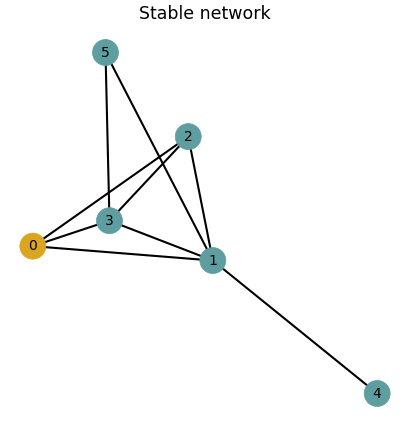

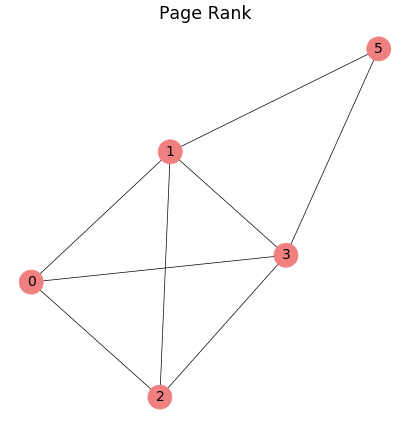

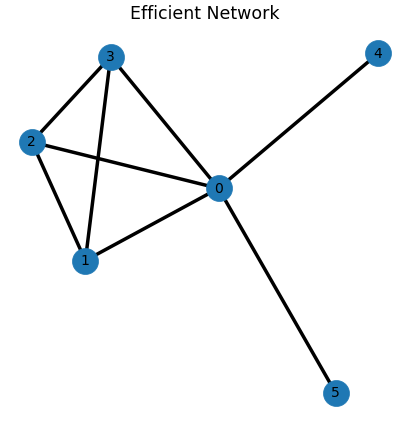

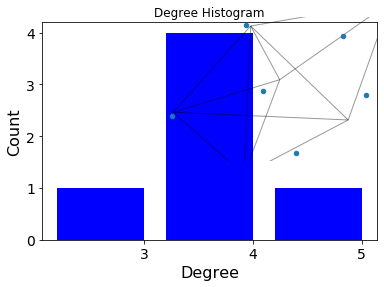

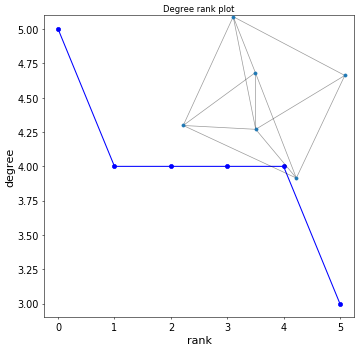

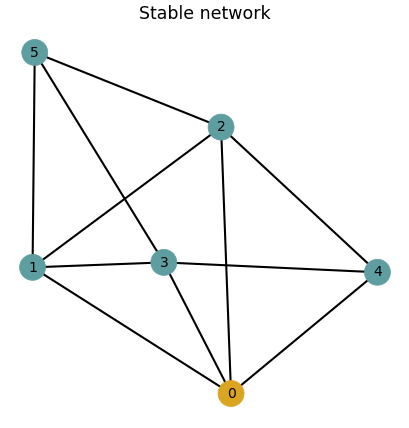

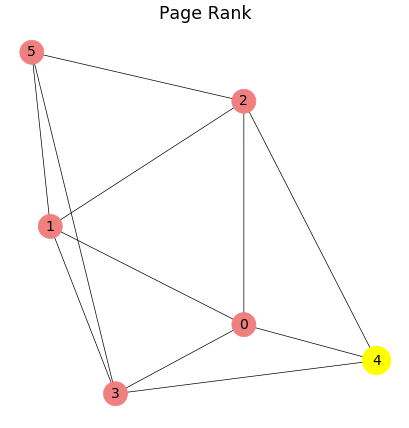

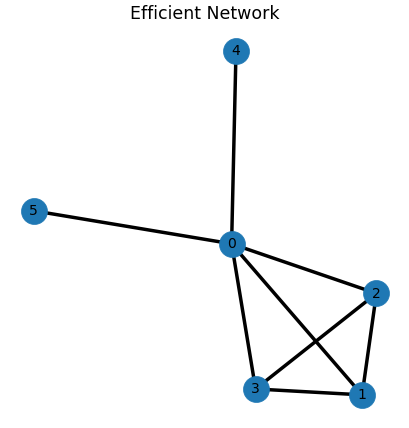

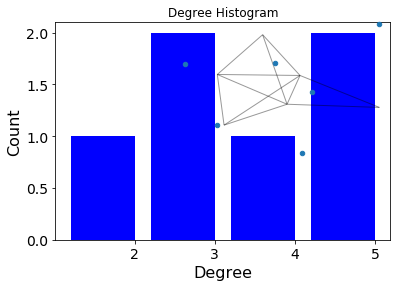

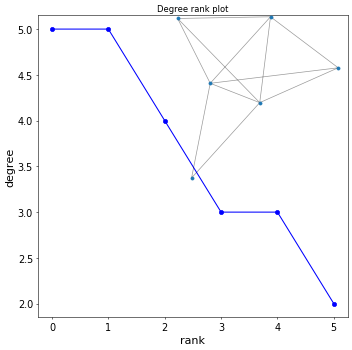

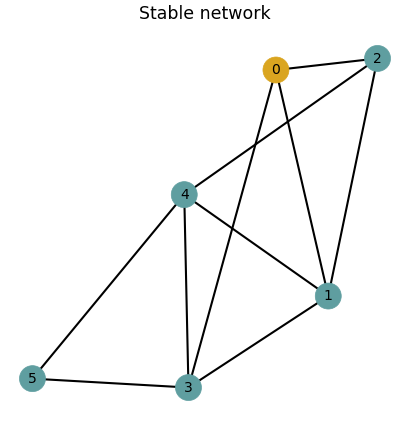

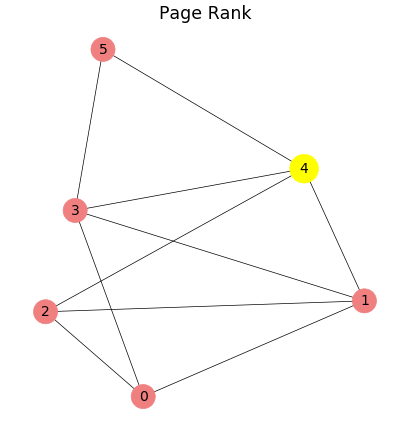

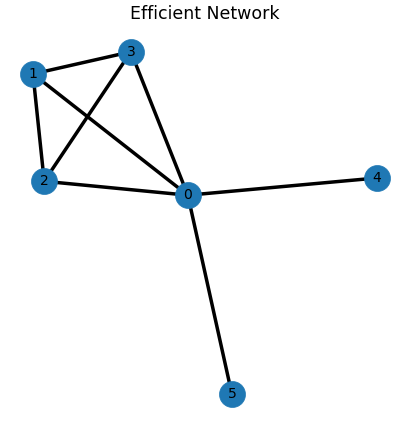

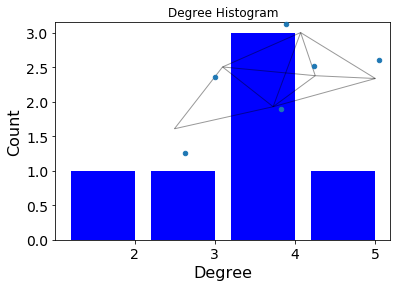

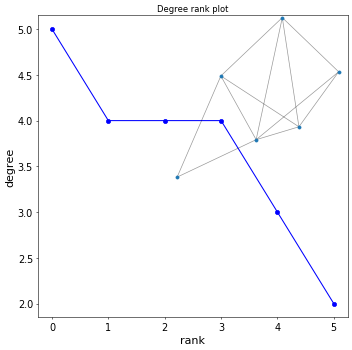

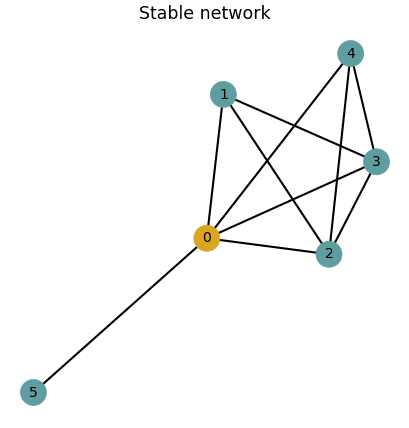

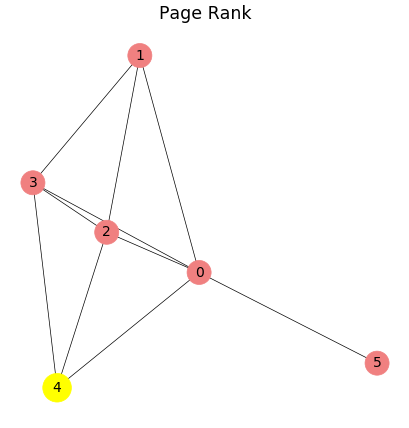

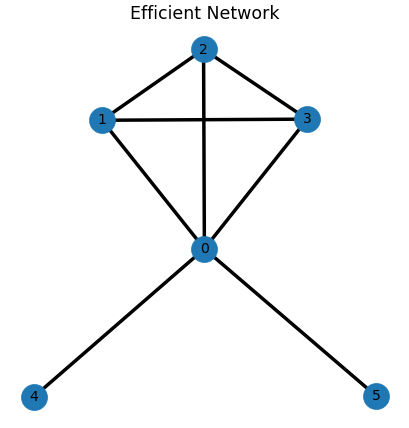

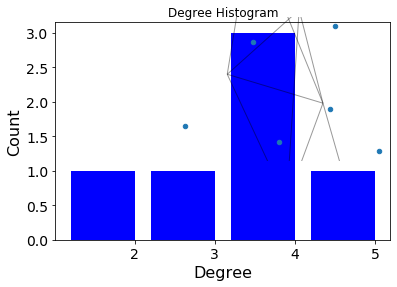

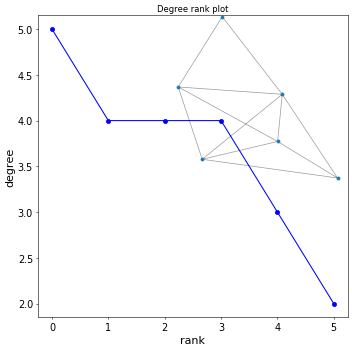

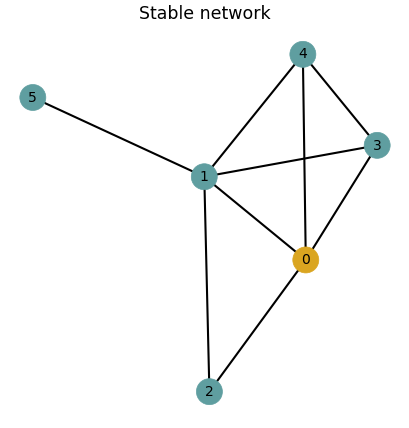

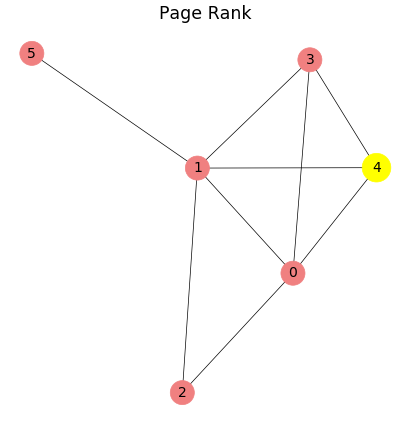

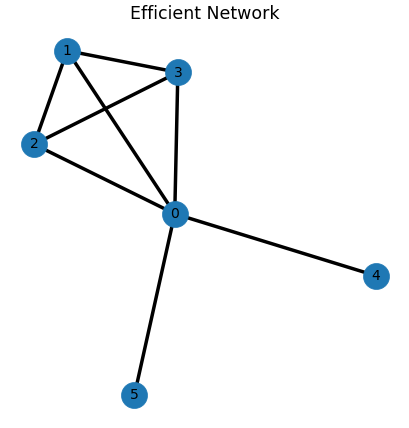

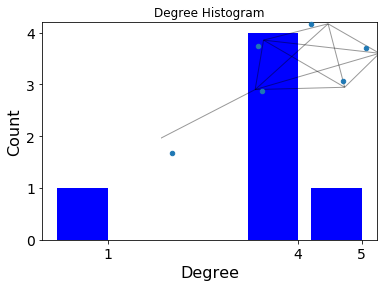

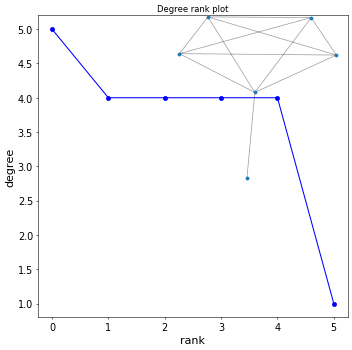

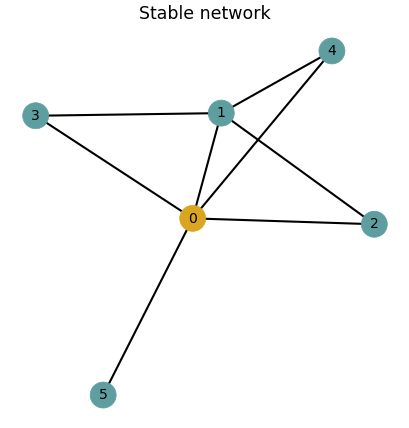

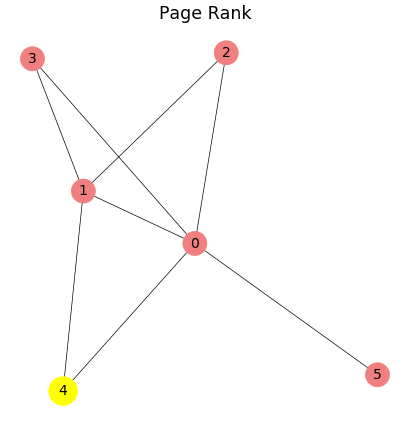

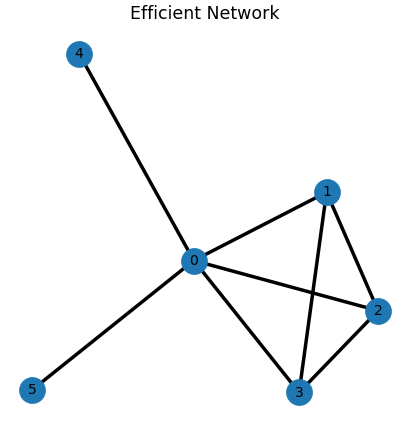

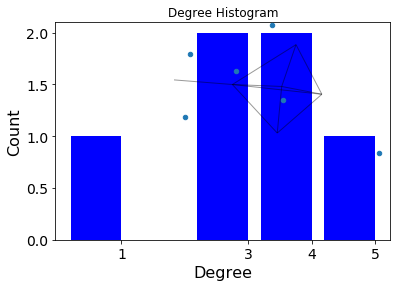

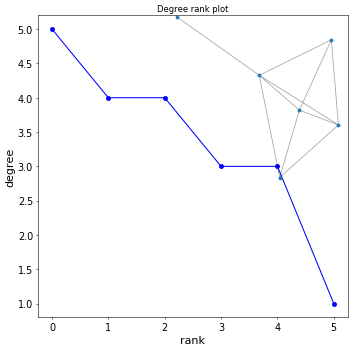

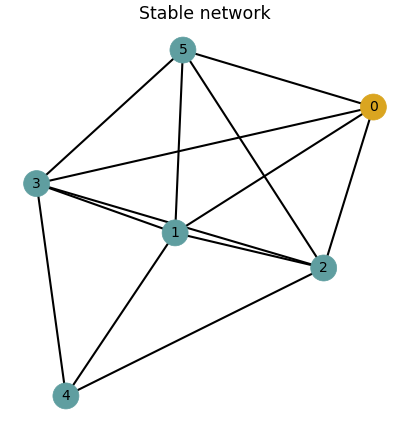

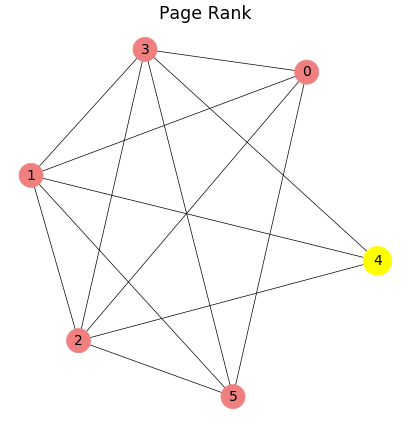

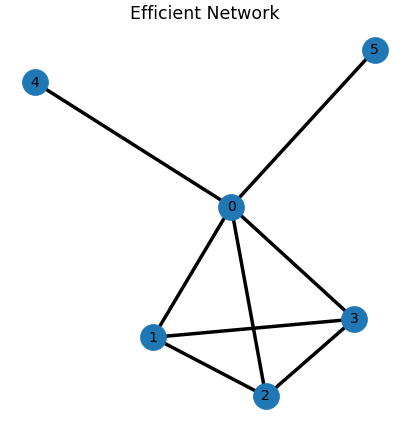

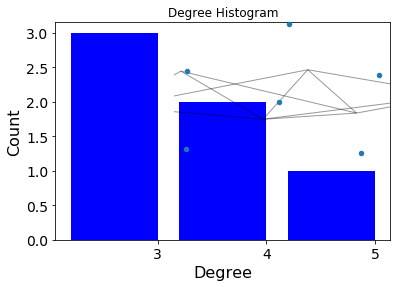

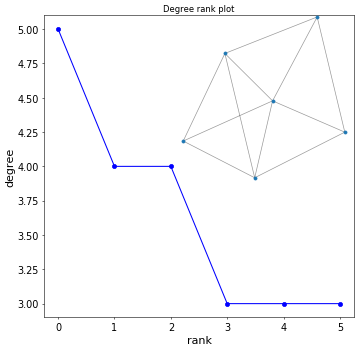

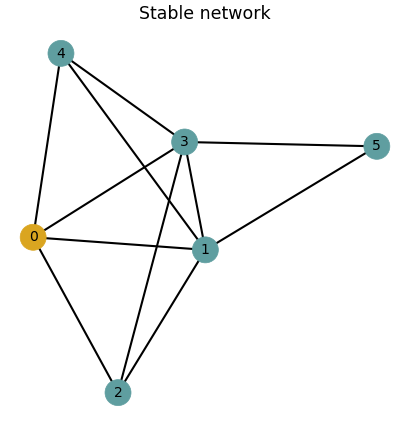

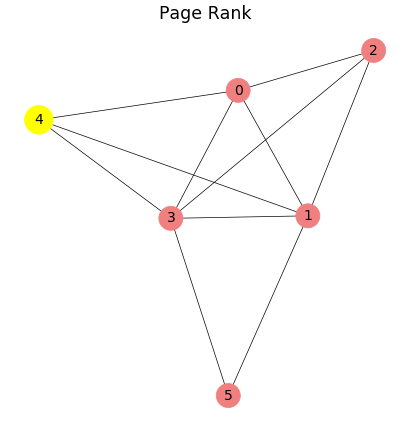

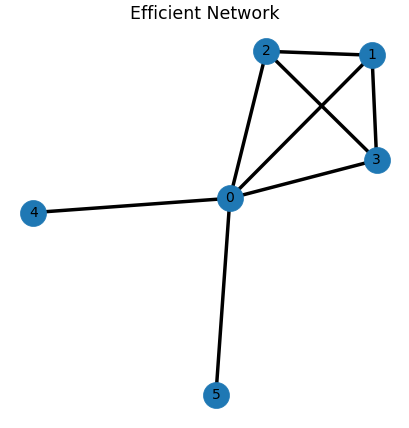

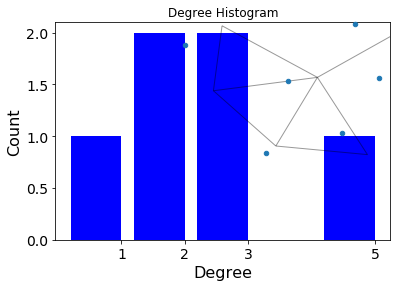

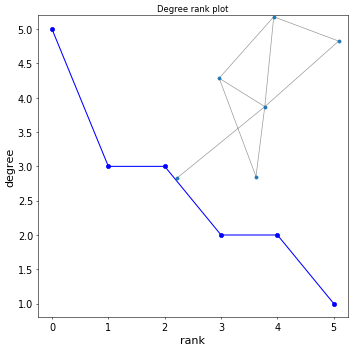

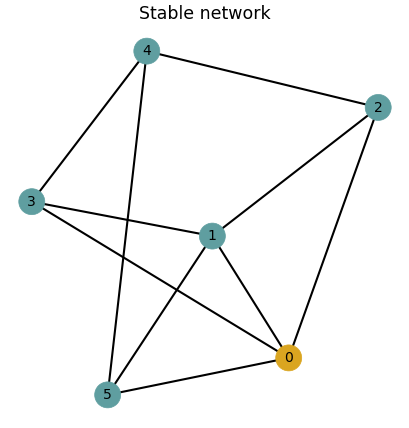

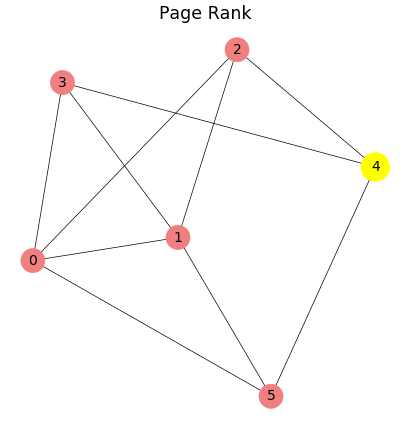

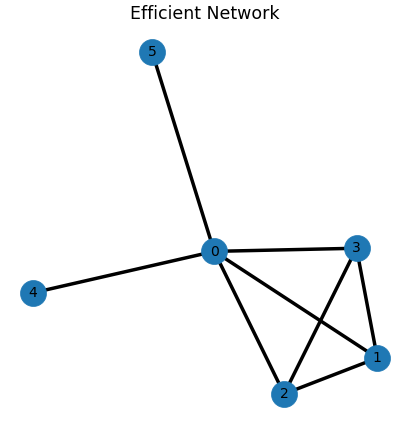

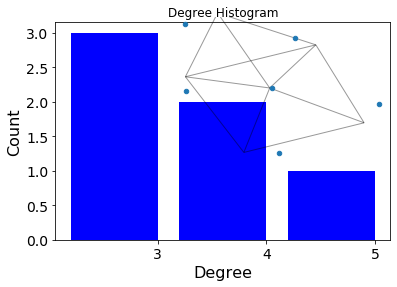

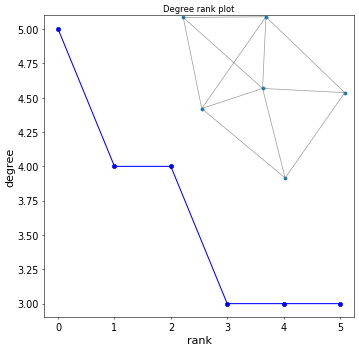

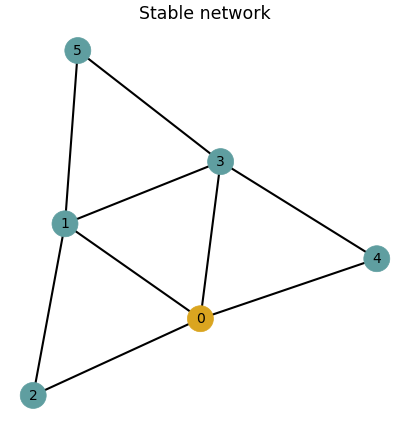

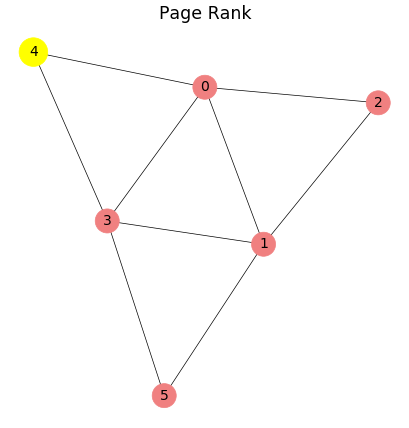

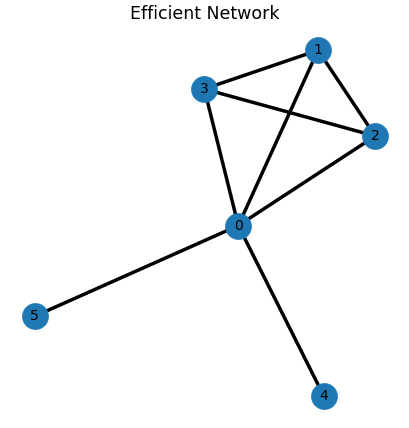

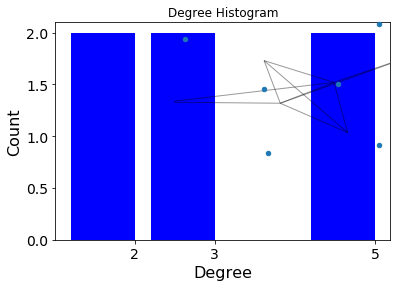

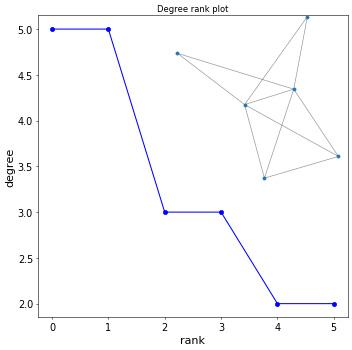

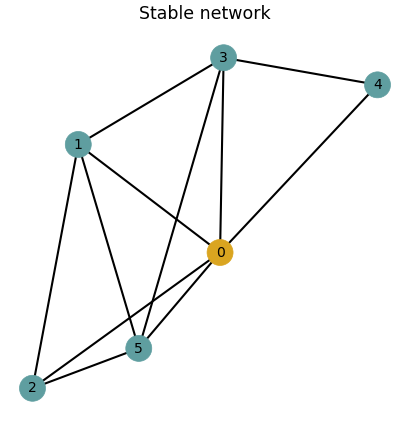

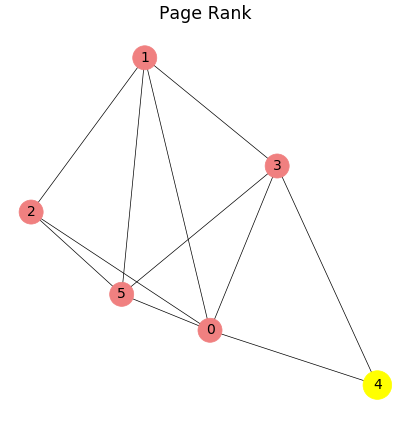

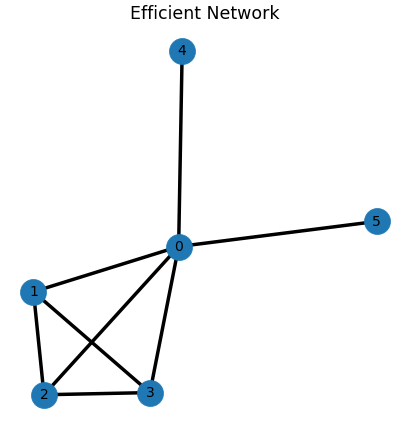

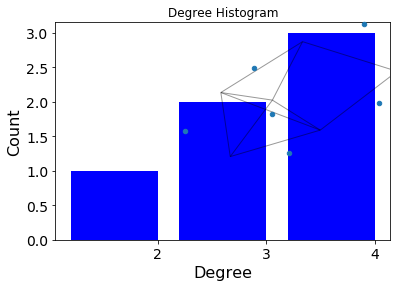

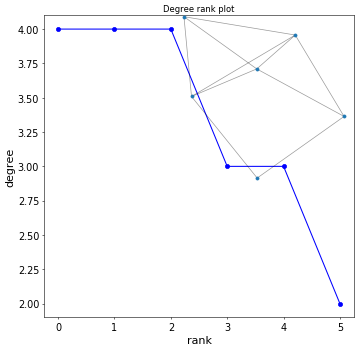

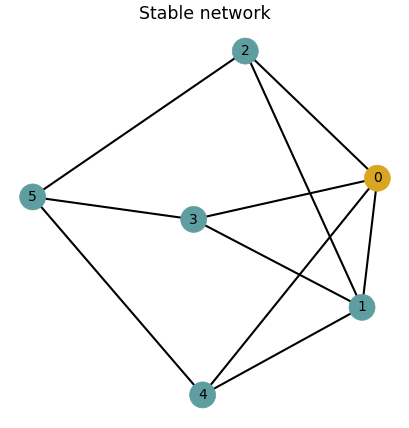

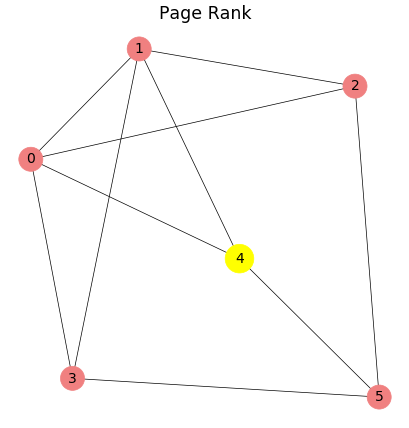

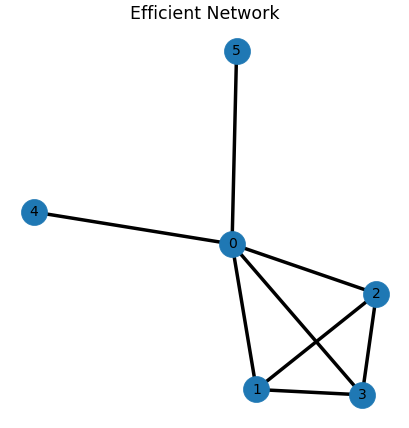

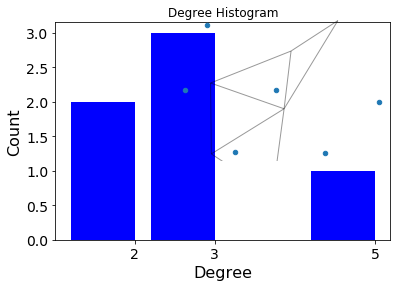

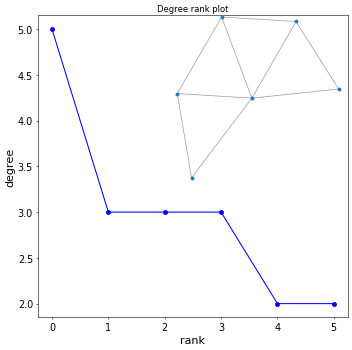

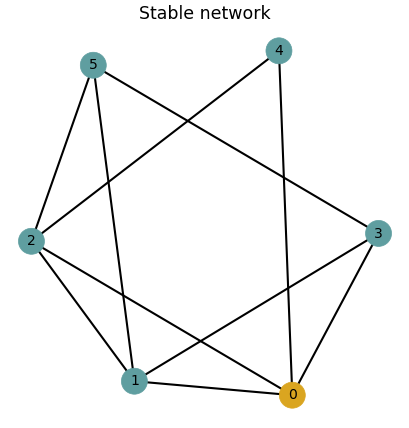

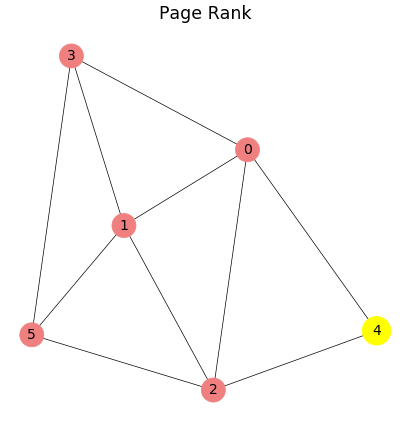

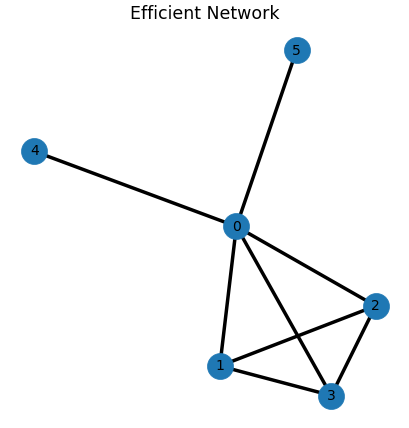

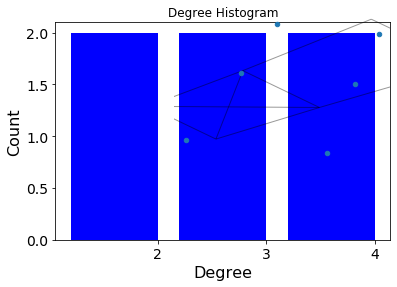

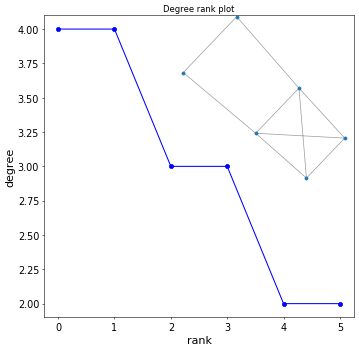

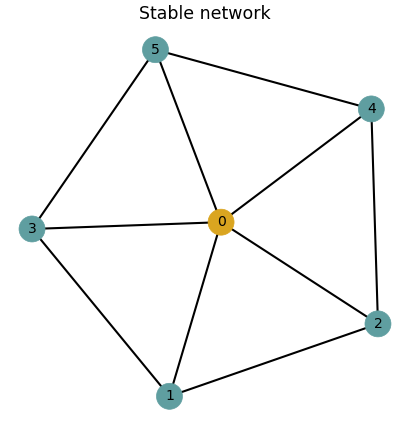

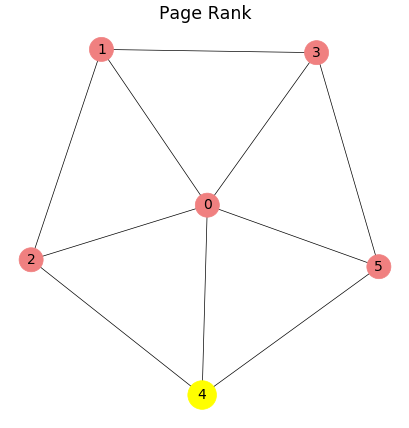

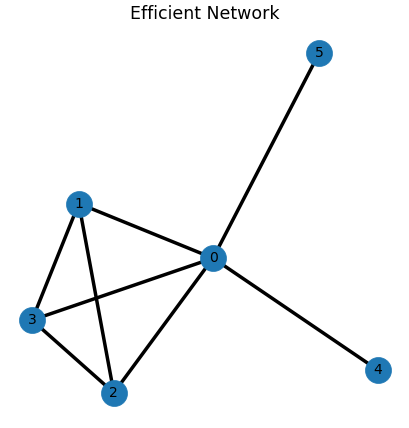

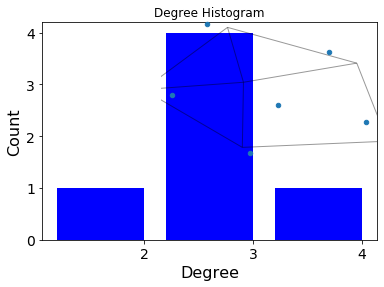

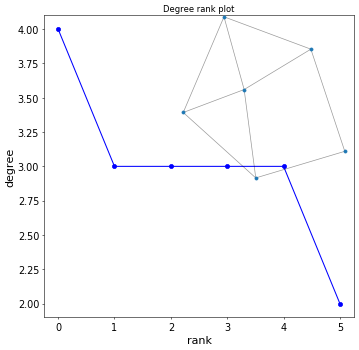

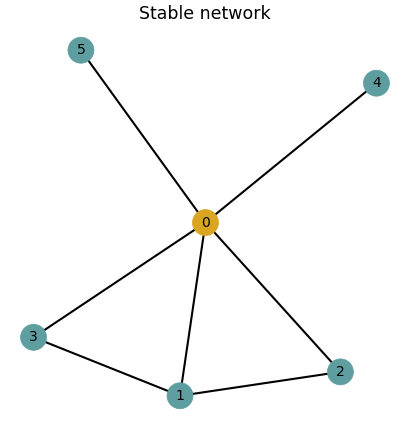

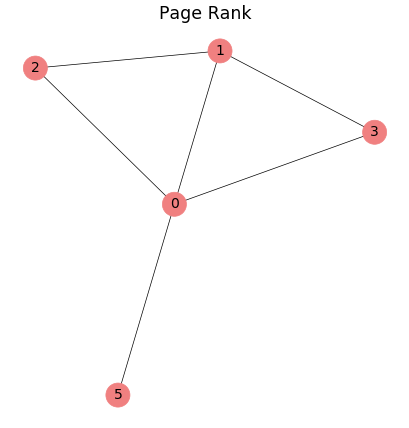

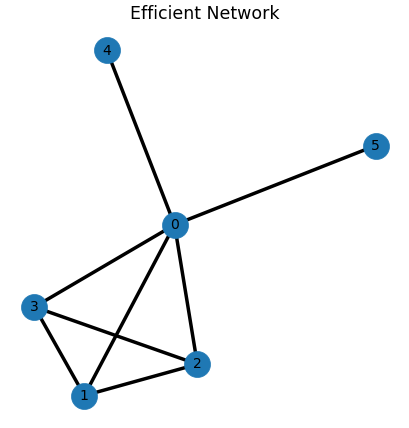

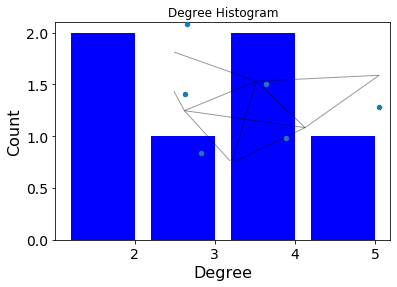

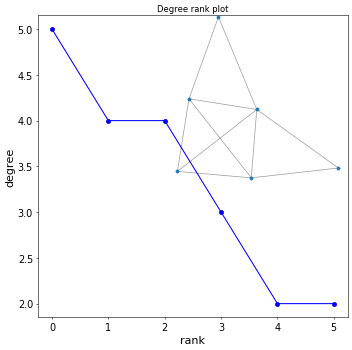

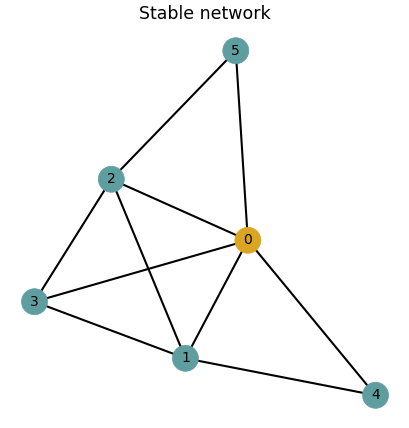

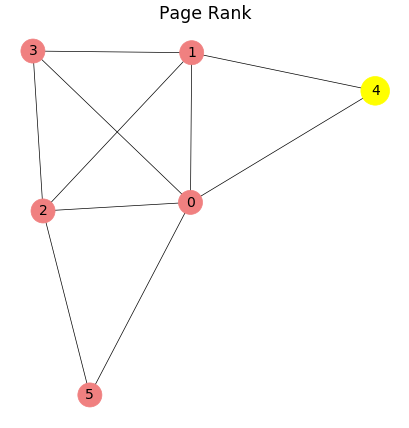

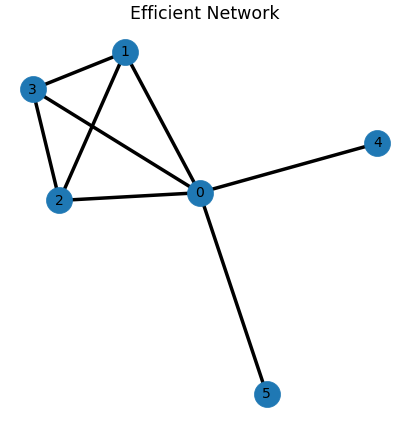

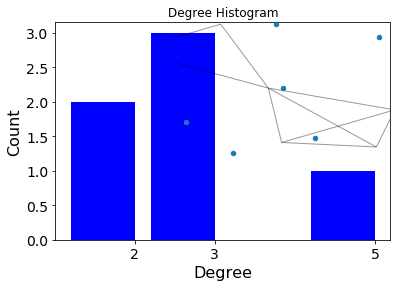

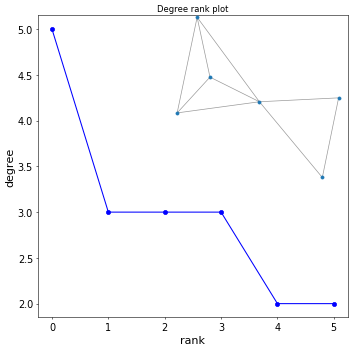

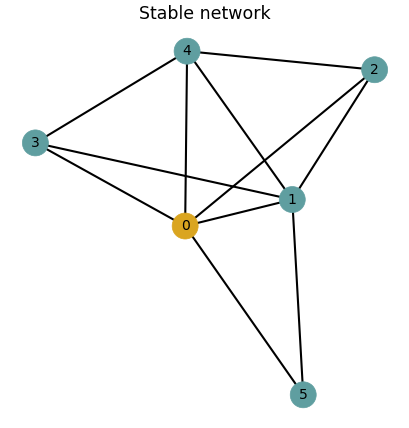

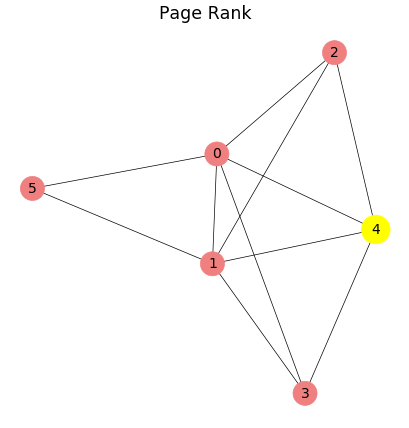

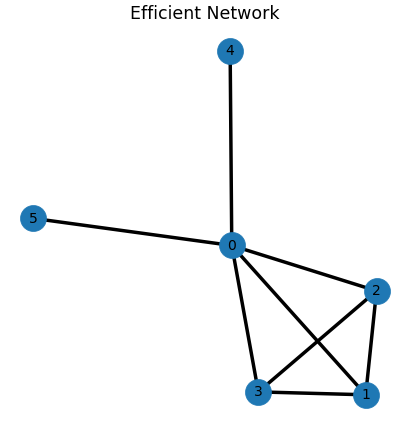

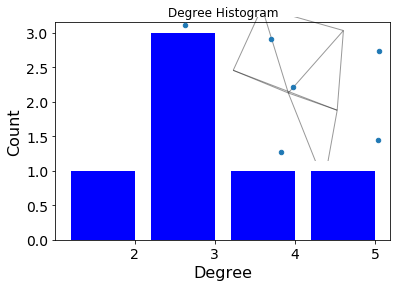

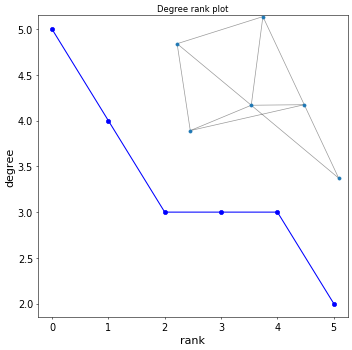

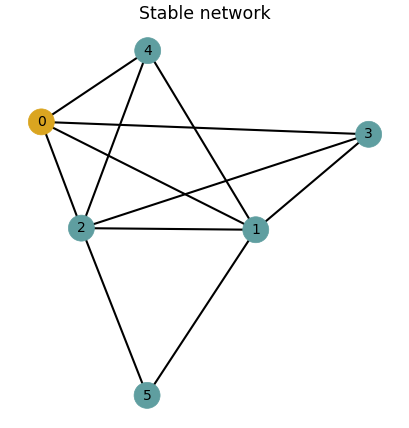

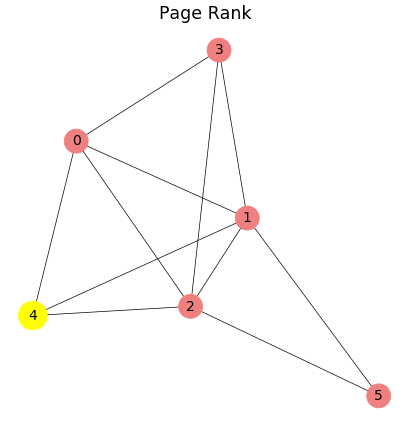

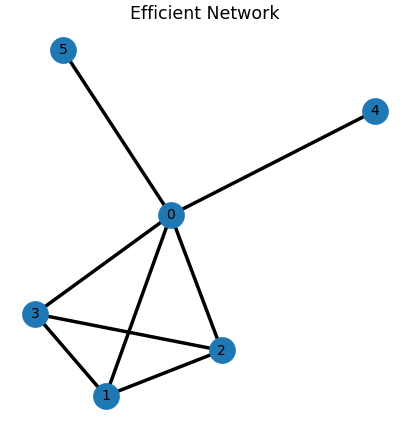

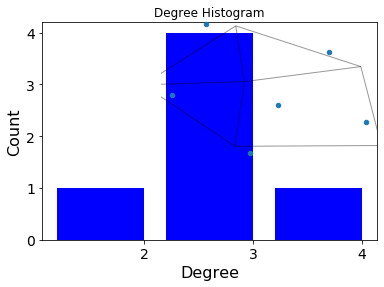

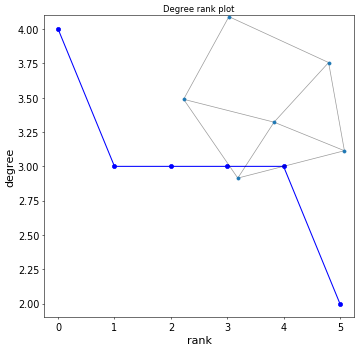

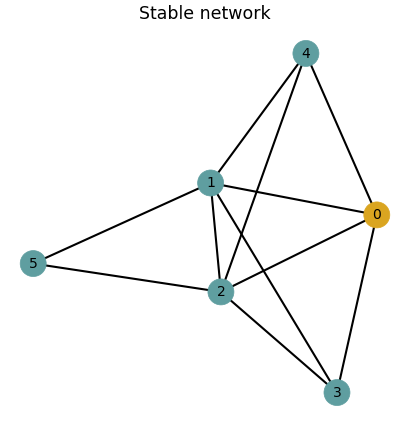

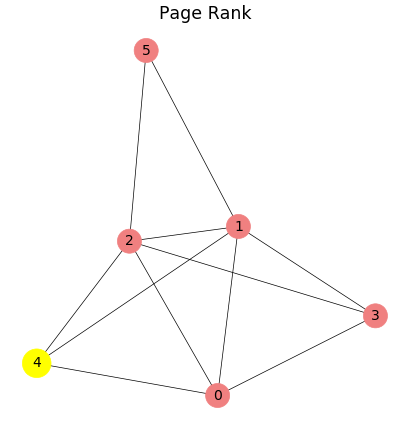

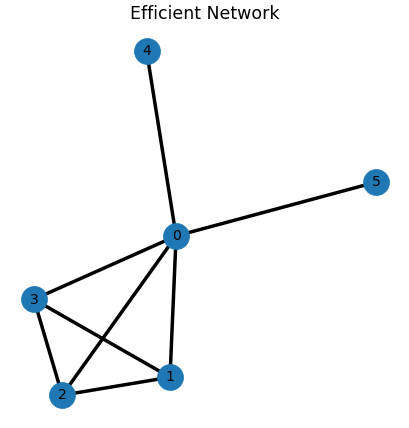

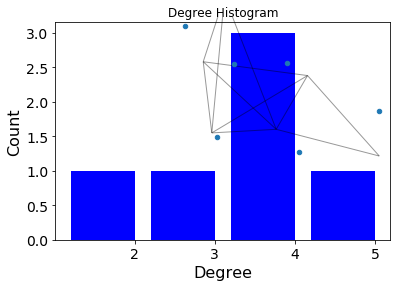

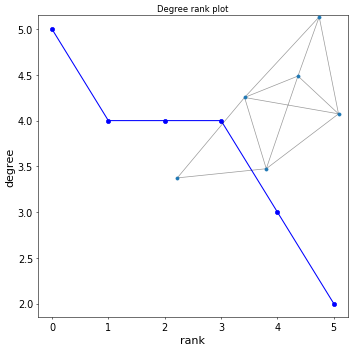

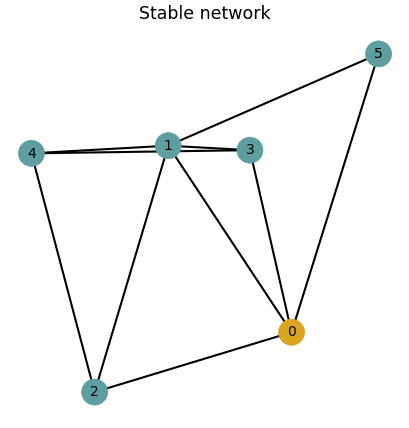

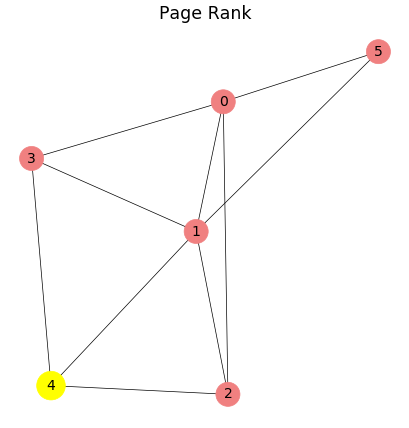

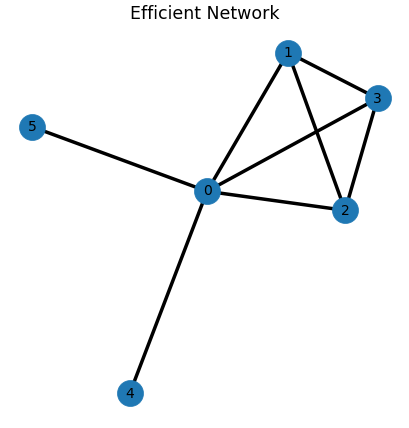

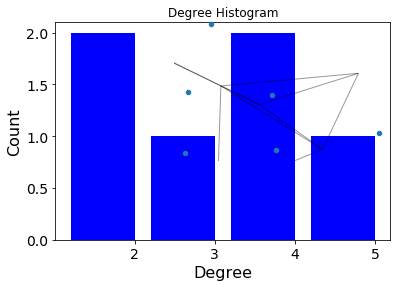

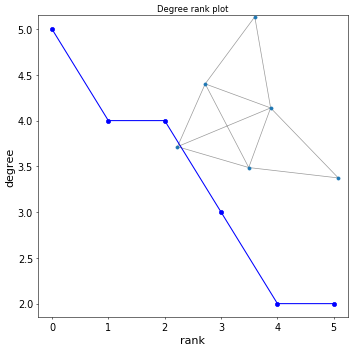

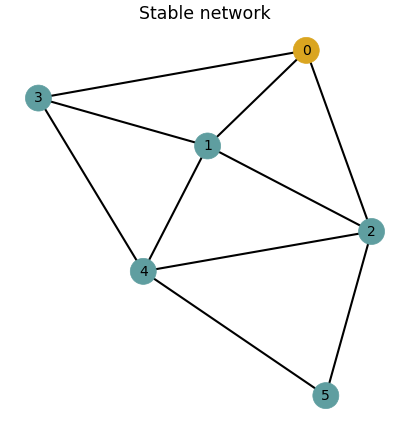

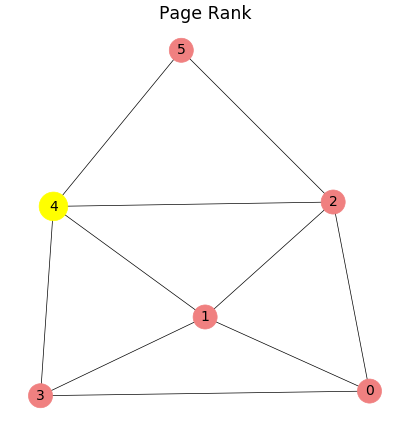

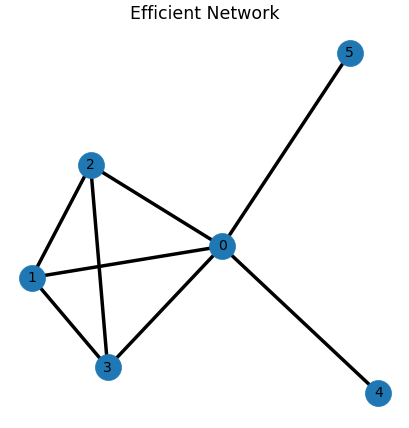

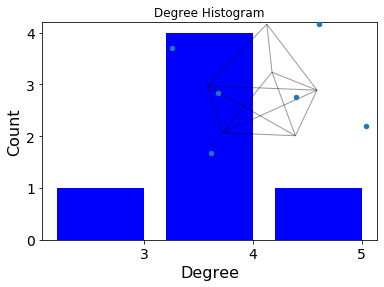

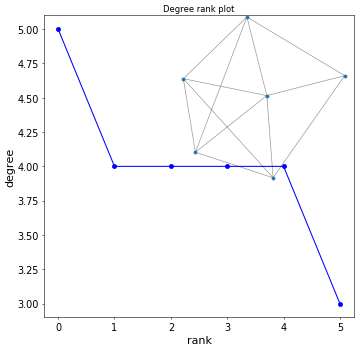

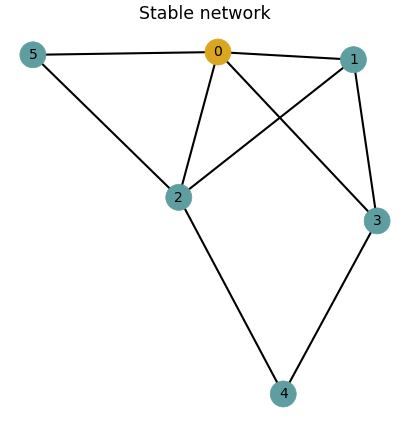

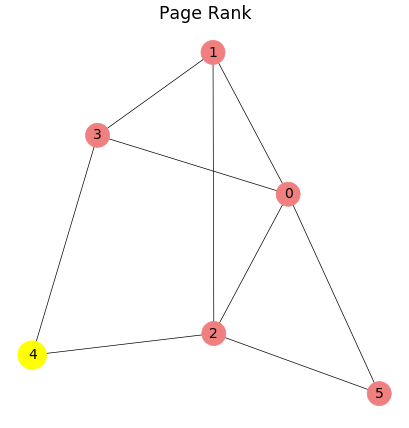

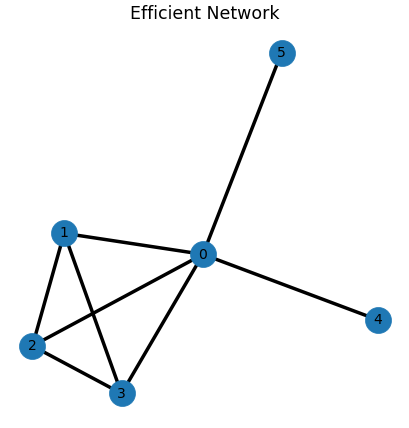

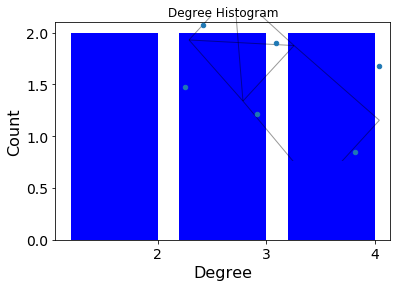

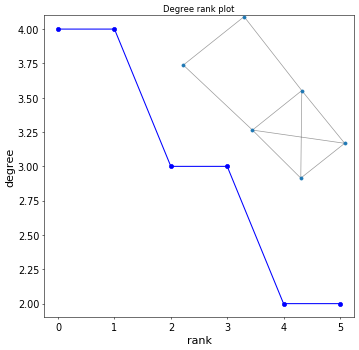

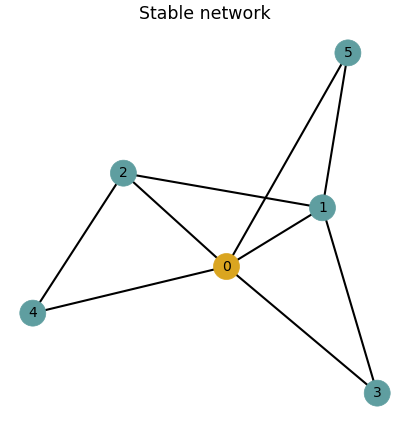

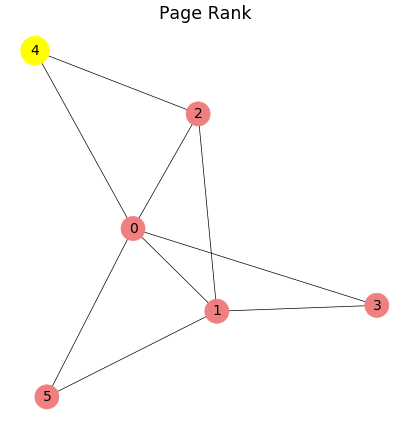

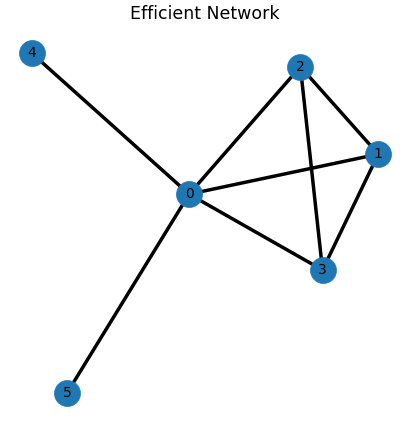

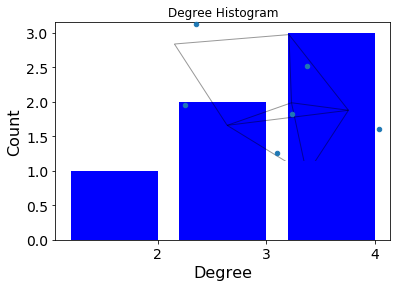

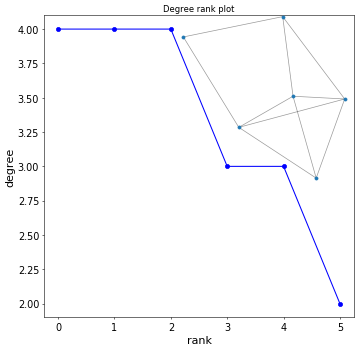

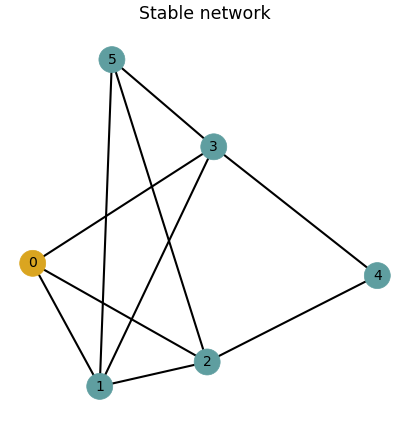

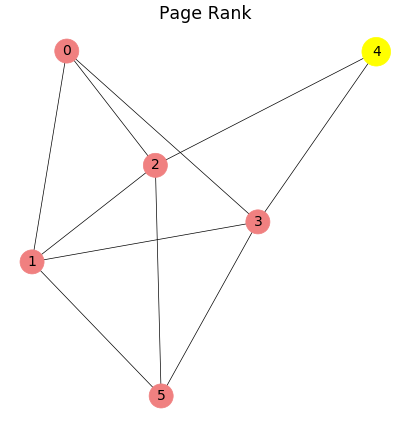

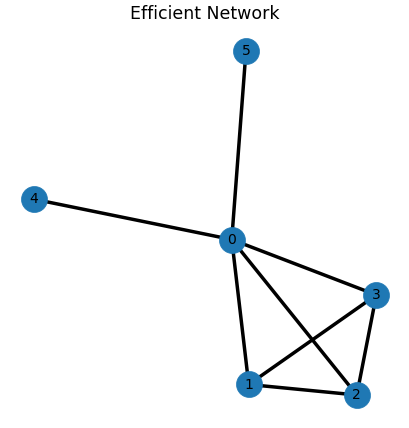

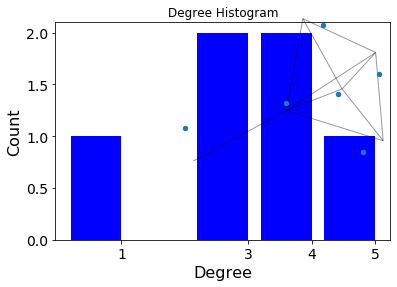

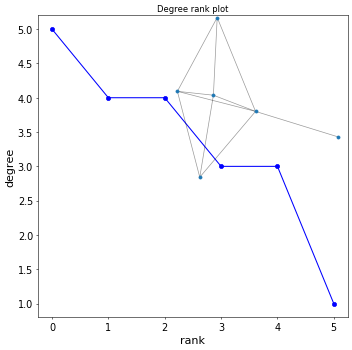

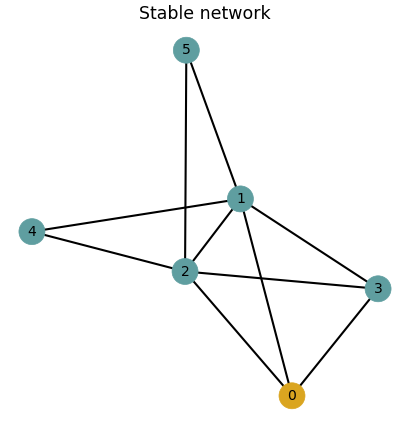

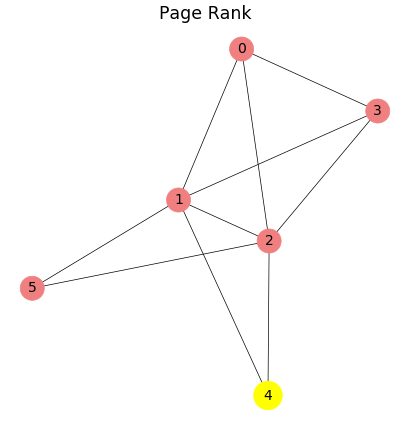

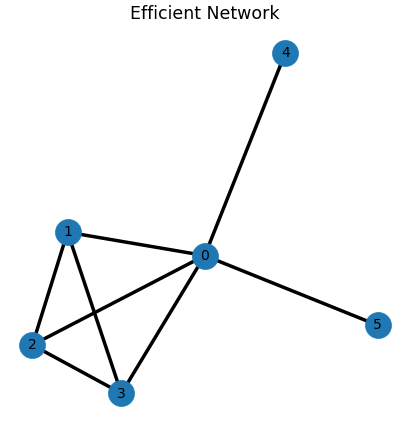

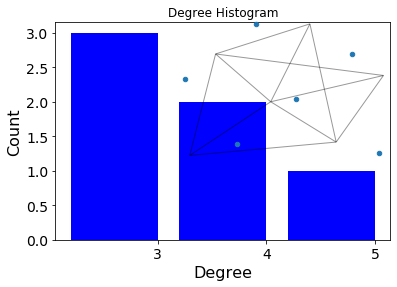

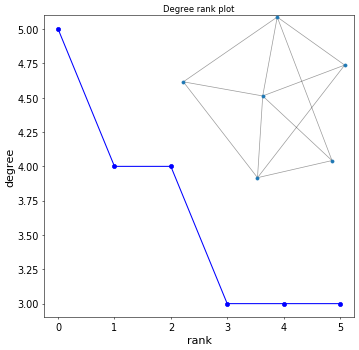

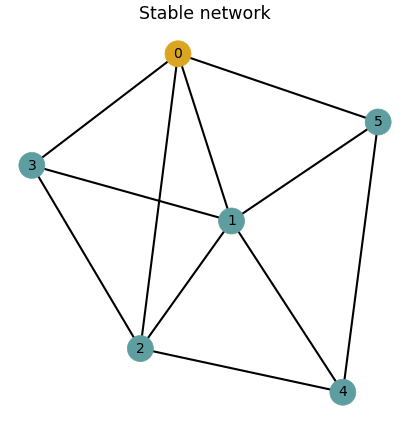

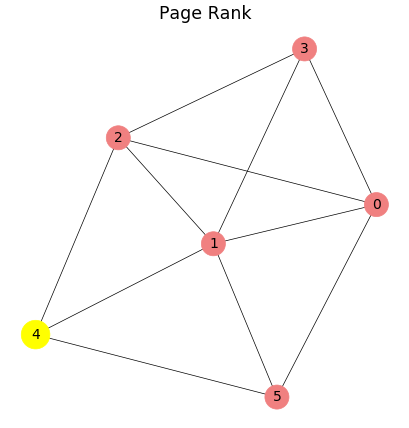

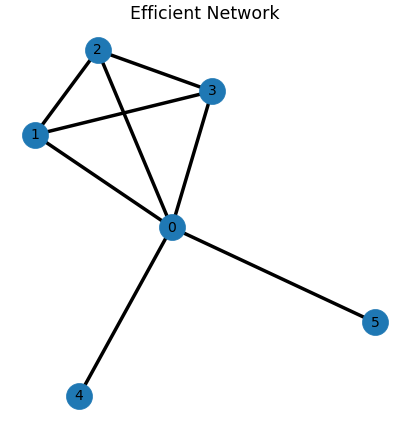

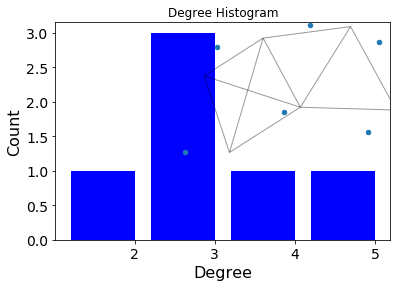

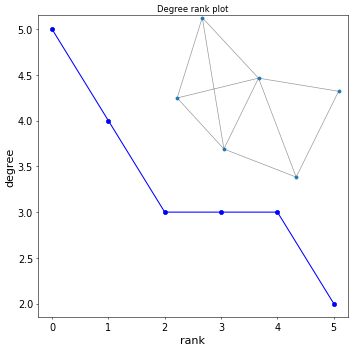

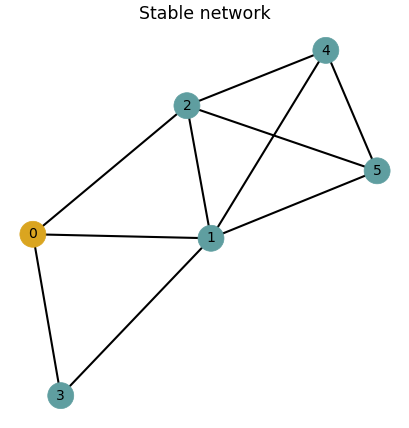

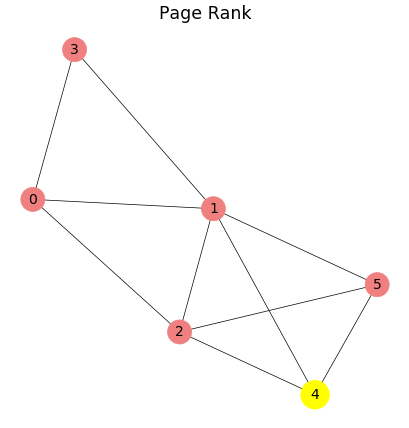

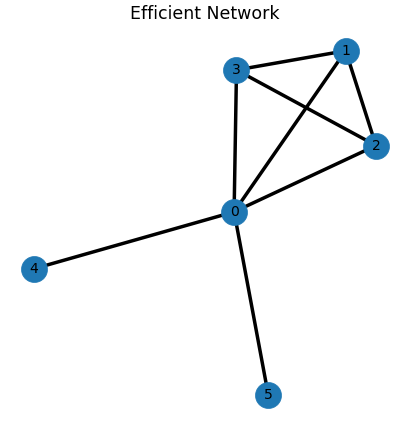

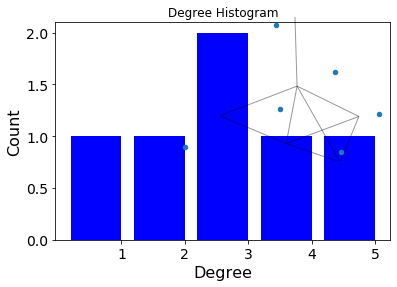

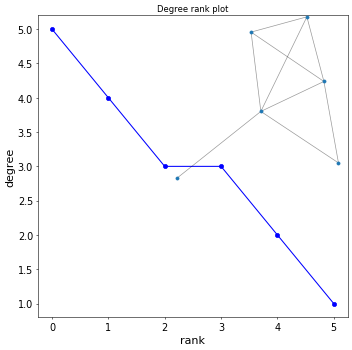

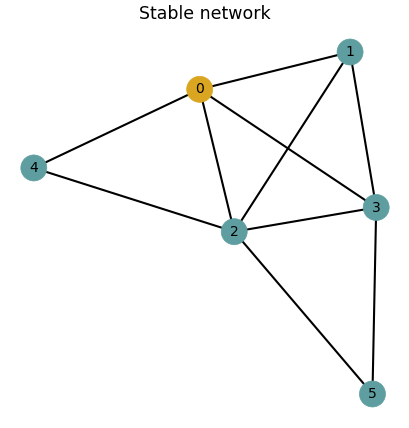

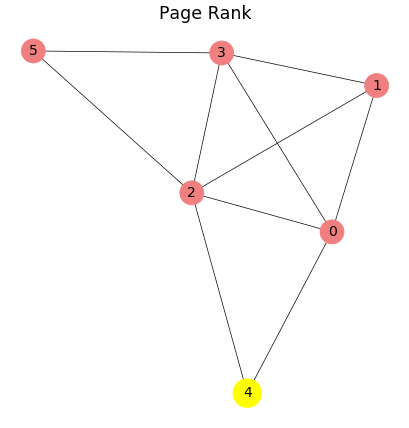

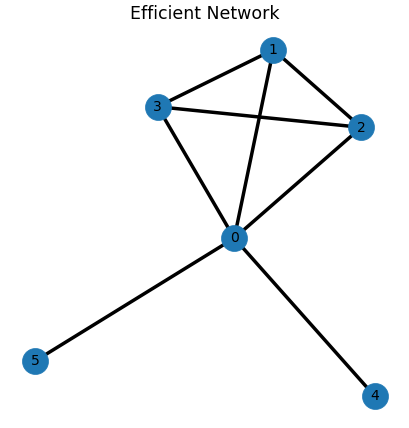

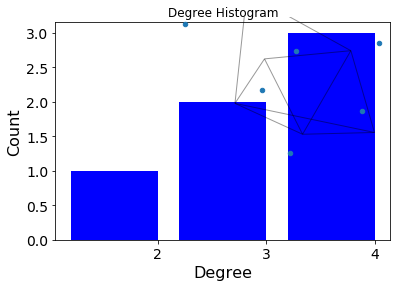

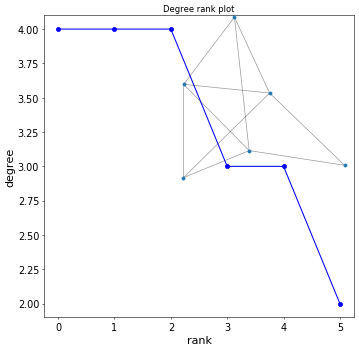

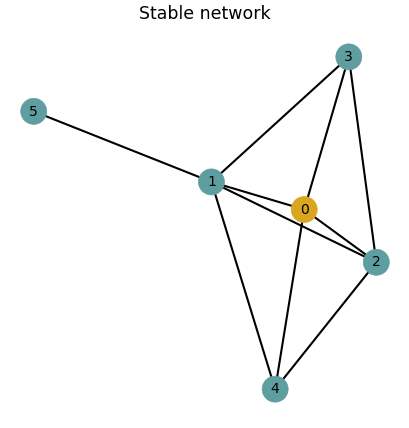

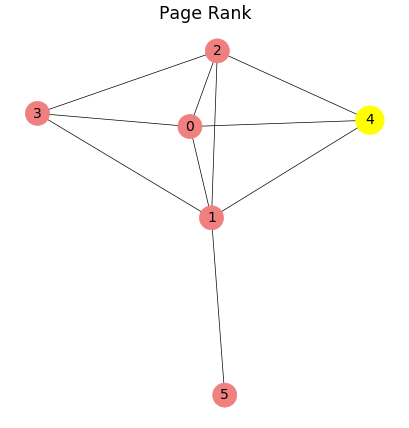

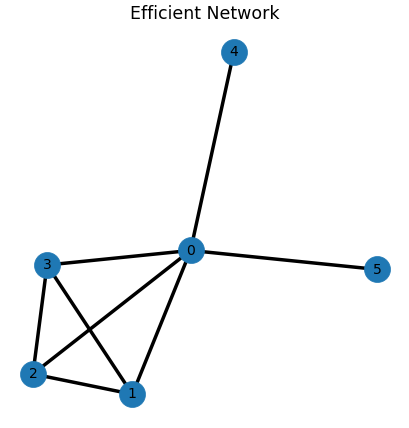

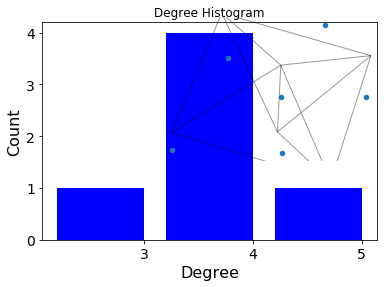

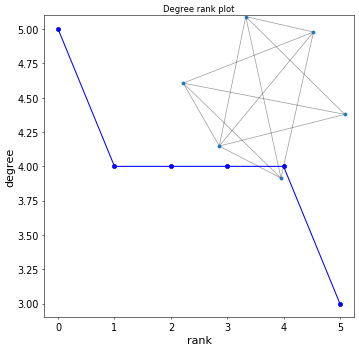

In [ ]:

"""10 nodes network benefit and cost"""
"""characteristics of stable networks""" 
# create a pdf file to store figures

#Cve=[0.2,0.3,0.4,1,1.2,1.3,1.5,1.6,1.8,1.9] #0<c<2, c<b1-b2
#b=[0,3.5,1.5,0.5,0.3]
#Cve=[1.6,1.8,1.9,2.1,2.2,2.3,2.5,2.6,2.8,2.9] #1.5<ci<3, 1=b1-b2<ci<b1=4
#b=[0,4,3,2,1]
#Cve=[0.2,0.5,0.7,1,1.2,1.6,2.0,2.6,2.8,2.9] #0<c<2, cj<b1-b2(=1.5)<ci<b1=4
#b=[0,4,2.5,1.5,0.3]

pp=PdfPages('/Users/layla/Documents/Jupyter_notebook_directory/output_values/graph_n6_3.pdf')
total_utility_stable=[] # initial stable network's total utilities list
node_utility_stable=[] # initial a list to store the node utility list of each stable network 
stable_matrix=[b,Cve] # initial adjacency matrix of each stable network
Efficiency_loss_list=[]
closeness_centrality=[]
betweenness_centrality=[]
eigenvector_centrality=[]
page_rank=[]
triangles=[]
clustering=[]

eccentricity=[]
diameter_radius_center_periphery_density=[]
transitivity=[]
effective_size=[]
closeness_vitality=[]
wiener_index=[]

for i in range(100):
    
    giant, node_stable_util_l,eff_utility, G_efficient,efficiency_loss,m=stable_network_characteristic(b,Cve)
    
    '''get the stable network adjacency matrix'''
    arraystable=nx.convert_matrix.to_numpy_array(giant)
    array=arraystable.tolist()
    
    if array in stable_matrix:
        break 
    
    stable_matrix.append(array)
    print("Iteration :", i)
    print('---Efficient Network(may not stable) Utility:',"{:.4f}".format(eff_utility))
    print('---Stable Network Utility:',"{:.4f}".format(total_utility(giant)))
    print('---Efficiency Loss of Stable Network:',"{:.4f}".format(efficiency_loss))
    '''get the efficiency loss list'''
    Efficiency_loss_list.append(round(efficiency_loss,4))

    '''total utilities of all stable networks'''
    total_utility_stable.append(total_utility(giant))

    '''append node utility list for each iteration'''
    node_utility_stable.append(node_stable_util_l)

    closeness_centrality.append(list(nx.closeness_centrality(giant).values()))
    betweenness_centrality.append(list(nx.betweenness_centrality(giant).values()))
    eigenvector_centrality.append(list(nx.eigenvector_centrality(giant).values()))
    page_rank.append(list(nx.pagerank(giant).values()))
    triangles.append(list(nx.triangles(giant).values()))
    clustering.append(list(nx.clustering(giant).values())) # clustering coefficient
    eccentricity.append(list(nx.eccentricity(giant).values()))
    effective_size.append(list(nx.effective_size(giant).values()))
    closeness_vitality.append(list(nx.closeness_vitality(giant).values()))

    wiener_index.append(nx.wiener_index(giant))
    transitivity.append(nx.transitivity(giant))

    diameter_radius_center_periphery_density.append([nx.diameter(giant),nx.radius(giant),nx.center(giant),nx.periphery(giant),nx.density(giant)])
    numbers_isolated=nx.number_of_isolates(giant)
    print('The Largest m:', m)
    print('Numbers of Isolated Nodes:',numbers_isolated)
    fig_stable_1,fig_pagerank_1,fig_efficient_1 =figure_stable(b,Cve) 
    pp.savefig(fig_stable_1)
    pp.savefig(fig_pagerank_1) 
    pp.savefig(fig_efficient_1)

    # print "Degree sequence", degree_sequence
    degree_sequence = sorted([d for n, d in giant.degree()], reverse=True)  # degree sequence

    degreeCount = collections.Counter(degree_sequence)
    deg, cnt = zip(*degreeCount.items())

    fig_his, ax1 = plt.subplots()
    plt.bar(deg, cnt, width=0.80, color='b')

    plt.title("Degree Histogram")
    plt.ylabel("Count")
    plt.xlabel("Degree")
    ax1.set_xticks([d + 0.4 for d in deg])
    ax1.set_xticklabels(deg)
    dmax = max(degree_sequence)
    # draw graph in inset
    plt.axes([0.4, 0.4, 0.5, 0.5])
    G = giant.subgraph(sorted(nx.connected_components(giant), key=len, reverse=True)[0])

    plt.axis('off')
    nx.draw_networkx_nodes(giant, pos = nx.spring_layout(giant), node_size=20)
    nx.draw_networkx_edges(giant, pos = nx.spring_layout(giant), alpha=0.4)

    fig_plot=plt.figure(figsize=(8,8),dpi=50)
    plt.plot(degree_sequence, 'b-', marker='o')
    plt.title("Degree rank plot")
    plt.ylabel("degree")
    plt.xlabel("rank")

    # draw graph in inset
    plt.axes([0.45, 0.45, 0.45, 0.45])

    pos = nx.spring_layout(G)
    plt.axis('off')
    nx.draw_networkx_nodes(G, pos, node_size=20)
    nx.draw_networkx_edges(G, pos, alpha=0.4)

    plt.show()

    pp.savefig(fig_his)
    pp.savefig(fig_plot)
pp.close()

# convert list to dataframe
node_utility_df=pd.DataFrame(node_utility_stable)
stable_matrix=pd.DataFrame(stable_matrix)
Efficiency_loss=pd.DataFrame(Efficiency_loss_list)
diameter_radius_center_periphery_density=pd.DataFrame(diameter_radius_center_periphery_density)

wiener_index_df=pd.DataFrame(wiener_index)
transitivity_df=pd.DataFrame(transitivity)

closeness_df=pd.DataFrame(closeness_centrality)
betweenness_df=pd.DataFrame(betweenness_centrality)
eigenvector_df=pd.DataFrame(eigenvector_centrality)
page_rank_df=pd.DataFrame(page_rank)
triangles_df=pd.DataFrame(triangles)
clustering_df=pd.DataFrame(clustering)
eccentricity_df=pd.DataFrame(eccentricity)
effective_size_df=pd.DataFrame(effective_size)
closeness_vitality_df=pd.DataFrame(closeness_vitality)

# the largest utility of the stable and efficient networks
efficient_index=[index for index, value in enumerate(total_utility_stable) if value==max(total_utility_stable)]

print('Efficient network index: ', efficient_index)   

print('Efficiency loss network list', Efficiency_loss_list)

#write dataframe to excel
with pd.ExcelWriter('/Users/layla/Documents/Jupyter_notebook_directory/output_values/output_n6_3.xlsx') as writer:
        #node_utility_df.to_excel(writer,sheet_name="node utility")
        #stable_matrix.to_excel(writer,sheet_name="matrix")
        closeness_df.to_excel(writer,sheet_name="closeness_centrality")
        betweenness_df.to_excel(writer,sheet_name="betweenness_centrality")
        eigenvector_df.to_excel(writer,sheet_name="eigenvector_centrality")
        page_rank_df.to_excel(writer,sheet_name="page_rank")
        triangles_df.to_excel(writer,sheet_name="triangles")
        clustering_df.to_excel(writer,sheet_name="clustering")
        wiener_index_df.to_excel(writer,sheet_name="wiener_index")
        transitivity_df.to_excel(writer,sheet_name="transitivity")
        eccentricity_df.to_excel(writer,sheet_name="eccentricity")
        
        diameter_radius_center_periphery_density.to_excel(writer,sheet_name="d_r_c_p_d")
        Efficiency_loss.to_excel(writer,sheet_name="Efficiency_loss")
        
